In [1]:
# Parameters
symbol = '^GSPC'
start_date = '1970'
leverage = 1.

In [2]:
# Parameters
symbol = "^GSPC"
leverage = 1.1


### Chiao Cheng <chiaolun@gmail.com>
### Inspirations
* https://theirrelevantinvestor.com/2019/02/08/miss-the-worst-days-miss-the-best-days/
* https://awealthofcommonsense.com/2020/03/what-if-you-buy-stocks-too-early-during-a-market-crash/
* https://awealthofcommonsense.com/2020/04/would-you-rather-buy-too-early-or-buy-too-late-in-a-bear-market/
* https://mebfaber.com/2019/11/04/is-buying-stocks-at-an-all-time-high-a-good-idea/

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

In [5]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [6]:
# Note that when using ^GSPC, there are no dividends, and it's also 
# not really directly tradeable - I'll do a continuous futures version 
# at some point

# Rest of analysis assumes non-stock allocation is in cash, 
# but in reality you would have some gains from being in bonds as well

# We add transaction costs further down this sheet

rets = data['Close'].transform(lambda xs: xs / xs.shift() - 1).rename('rets')
ma200 = data.Close.rolling(200).mean()

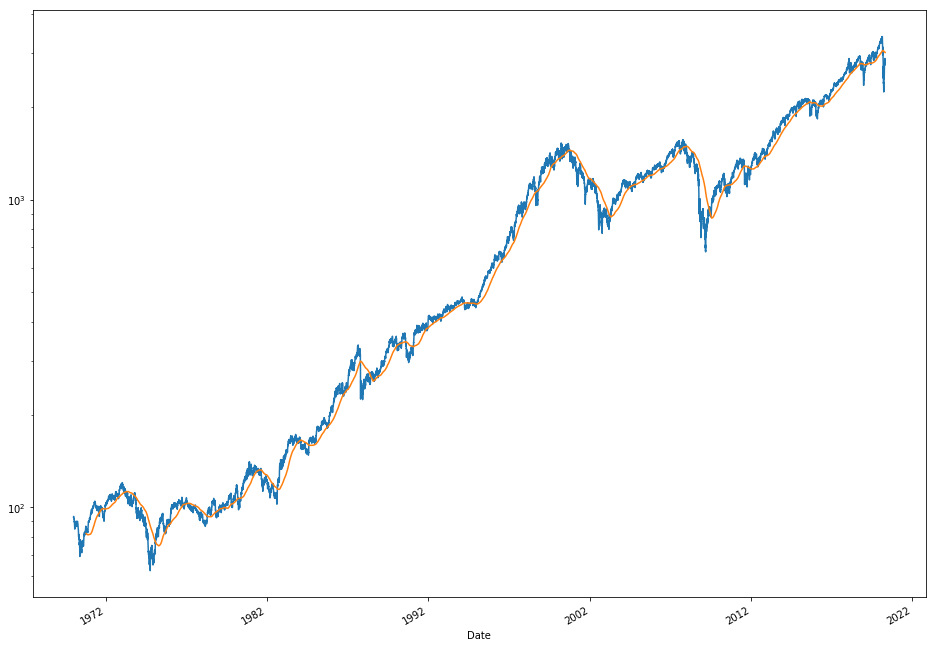

In [7]:
# The 200-day moving average (MA200) is a lagging, smoother version of the original data
data.Close.plot(logy=True)
ma200.plot(logy=True);

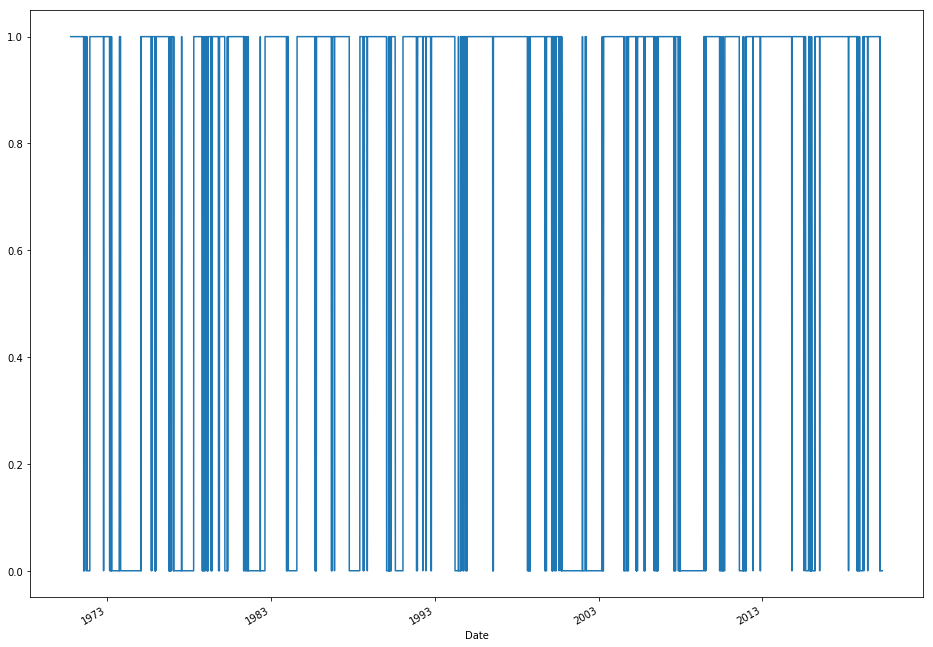

In [8]:
# It can be used for betting on momentum, doing market timing by being long when the close is above the MA200
position = (data.Close > ma200).astype(int)
position[ma200.isnull()] = np.nan
position = position.shift()  # Delay by one day
position.plot()

In [9]:
strats = pd.DataFrame({
    'buy_and_hold': 1, 
    'ma200': position * leverage
})

In [10]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

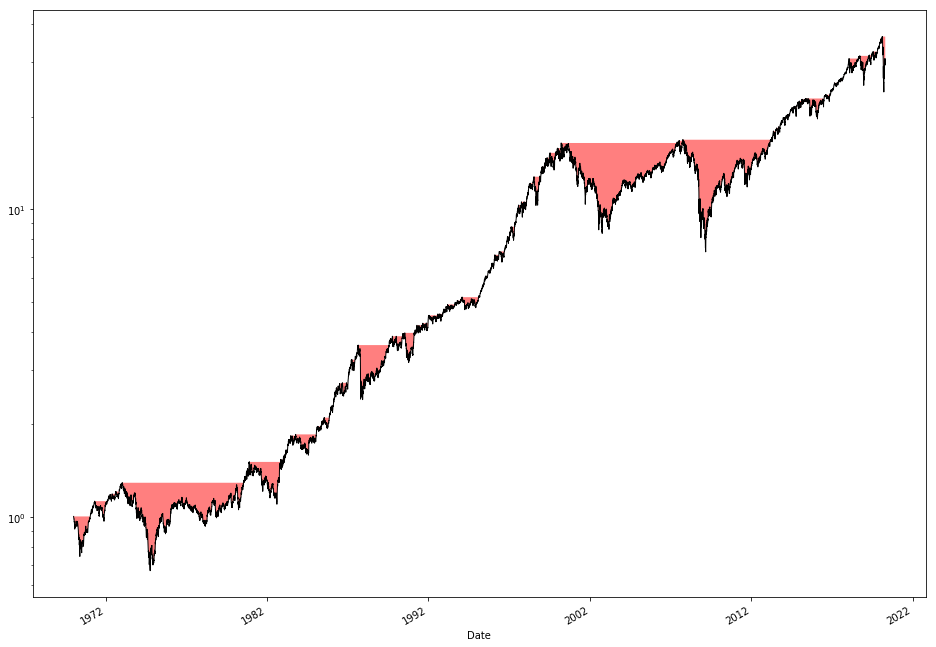

In [11]:
# This is the plain old SP500
plot_dd(strats.buy_and_hold.mul(rets, axis=0))

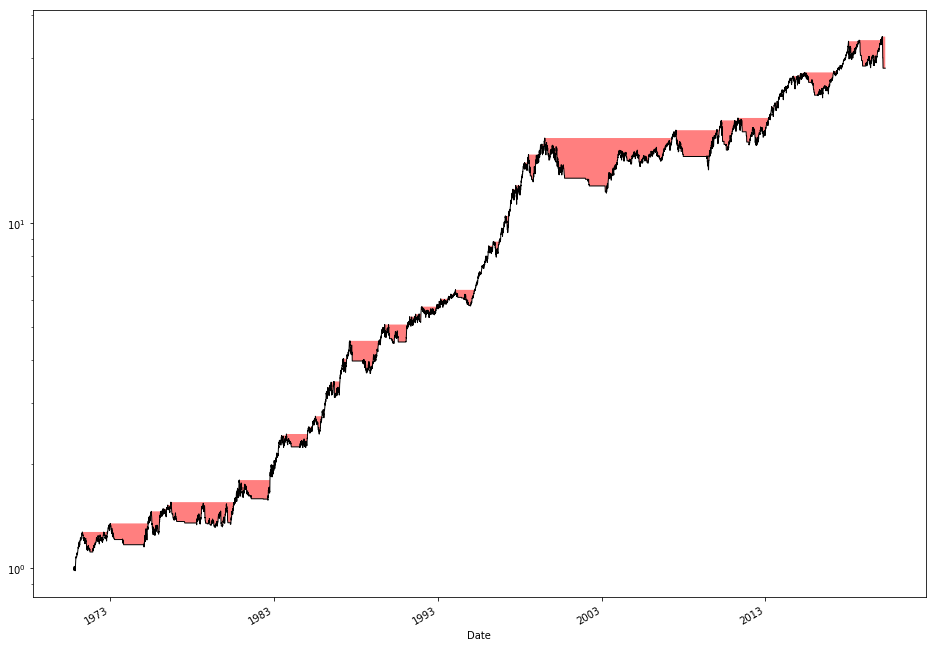

In [12]:
# This is with the MA200 crossover timing - the returns are lower but drawdowns are less deep
plot_dd(strats.ma200.mul(rets, axis=0))

In [13]:
# Slightly worse returns
strats.mul(rets, axis=0).add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

buy_and_hold    0.069646
ma200           0.069046
dtype: float64

In [14]:
# Better worst and average drawdown
(
    strats.mul(rets, axis=0)
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1)
    .agg(['min', 'mean'])
    .T
)

,min,mean
buy_and_hold,-0.567754,-0.113337
ma200,-0.307904,-0.083686


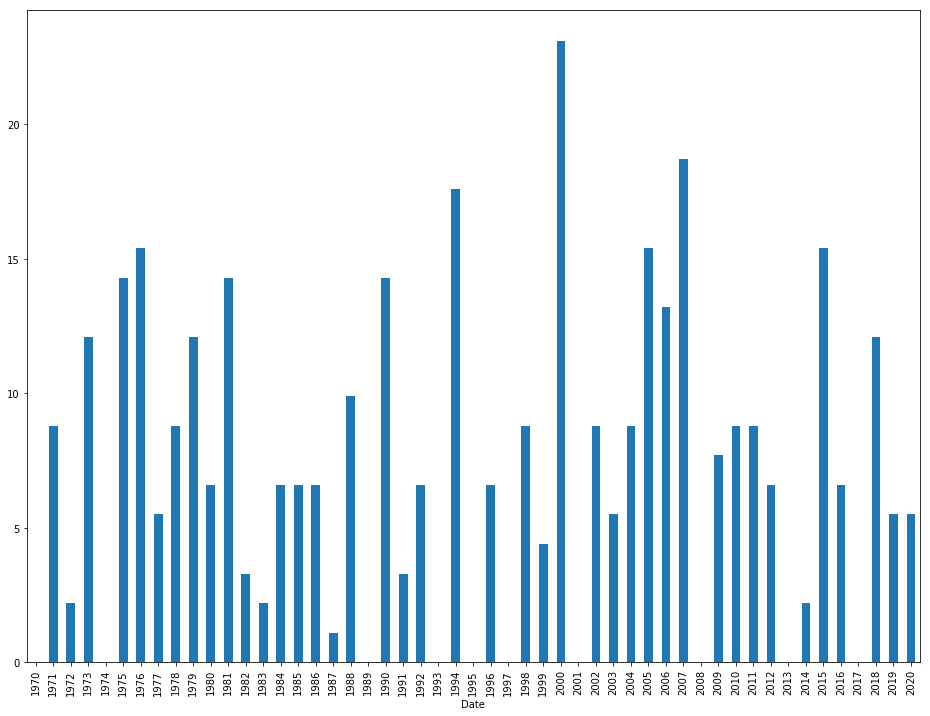

In [15]:
# These results are all before accounting for trading costs!
# Turnover can be awfully high - 20x in some years! You are trading in and out of the market a lot
# Some concerns about overfitting due to sensitivity to exactly when the crossings happen
(
    strats.ma200.diff().abs()
    .groupby(pd.Grouper(freq='Y')).sum()
    .rename(index=lambda xs: xs.year)
    .plot.bar()
)

In [16]:
# Let's smoothen the signal by acting slowly on it!
@numba.njit
def _smoothen(signal, nsteps, leverage):
    pos = np.zeros_like(signal, dtype=np.int64)
    signal = signal * nsteps * leverage
    pos[0] = nsteps
    for i in range(1, pos.shape[0]):
        if signal[i] > pos[i - 1]:
            d = leverage
        elif signal[i] < pos[i - 1]:
            d = -leverage
        else:
            d = 0
        pos[i] = pos[i - 1] + d
    return pos / nsteps


def smoothen(signal, nsteps, leverage):
    return pd.Series(
        _smoothen(signal.values, nsteps, leverage),
        index=signal.index
    )

In [17]:
strats['ma200_slow'] = smoothen(strats.ma200, 90, leverage)

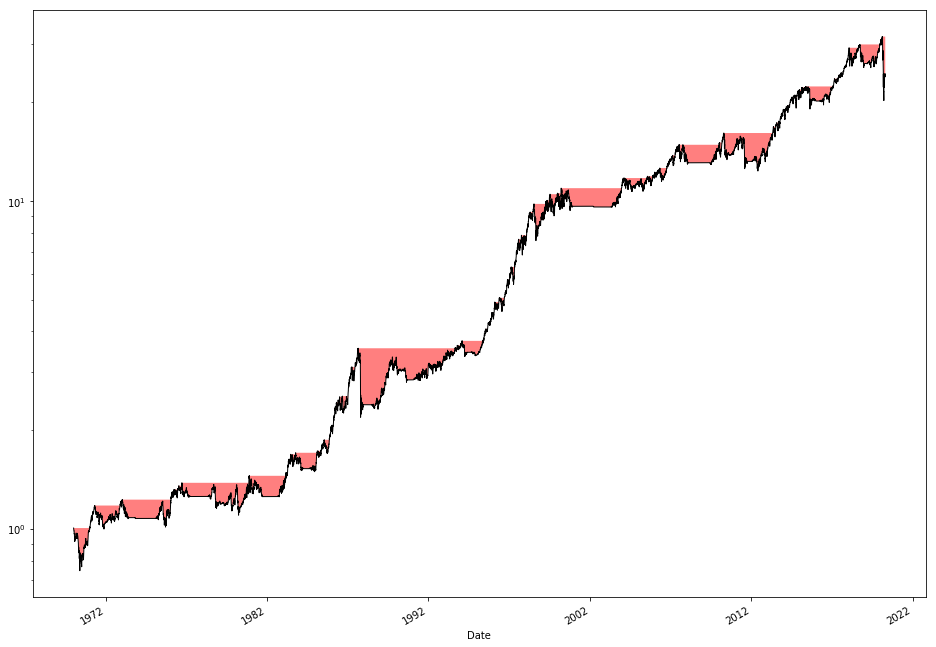

In [18]:
# Smoothed MA200 crossover
plot_dd(strats.ma200_slow * rets)

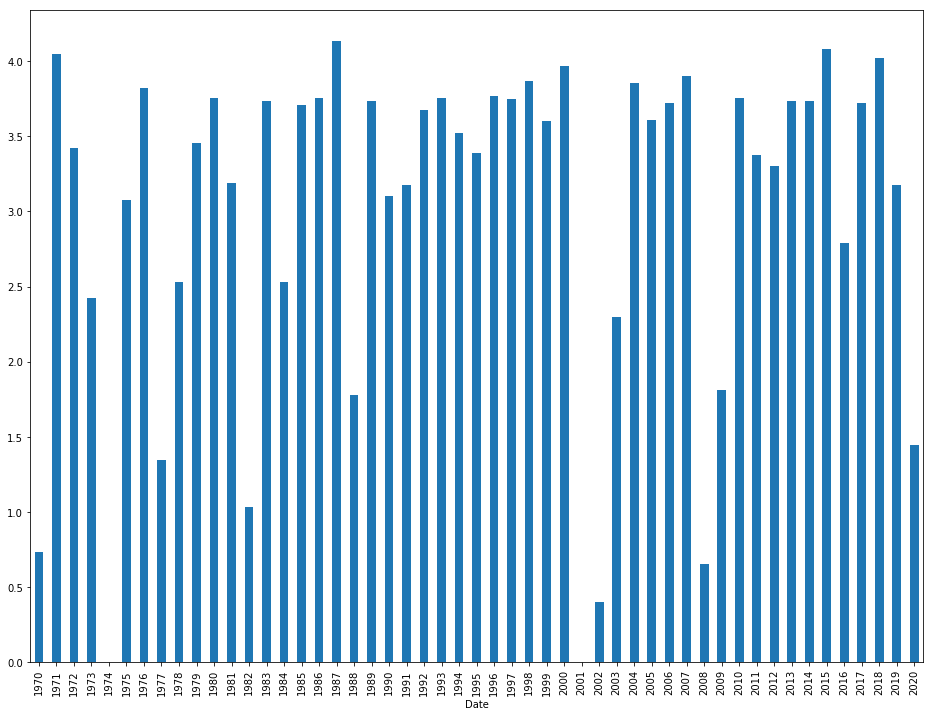

In [19]:
# Turnover is way down
(
    strats.ma200_slow.diff().abs()
    .groupby(pd.Grouper(freq='Y')).sum()
    .rename(index=lambda xs: xs.year)
    .plot.bar()
)

In [20]:
# Average annual returns
strats.mul(rets, axis=0).add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

buy_and_hold    0.069646
ma200           0.069046
ma200_slow      0.064810
dtype: float64

In [21]:
# Sharpe ratios
strats.mul(rets, axis=0).agg(lambda xs: xs.mean() / xs.std() * 250**0.5)

buy_and_hold    0.479906
ma200           0.615546
ma200_slow      0.515159
dtype: float64

      buy_and_hold     ma200  ma200_slow
min      -0.567754 -0.307904   -0.384010
mean     -0.113337 -0.083686   -0.084471


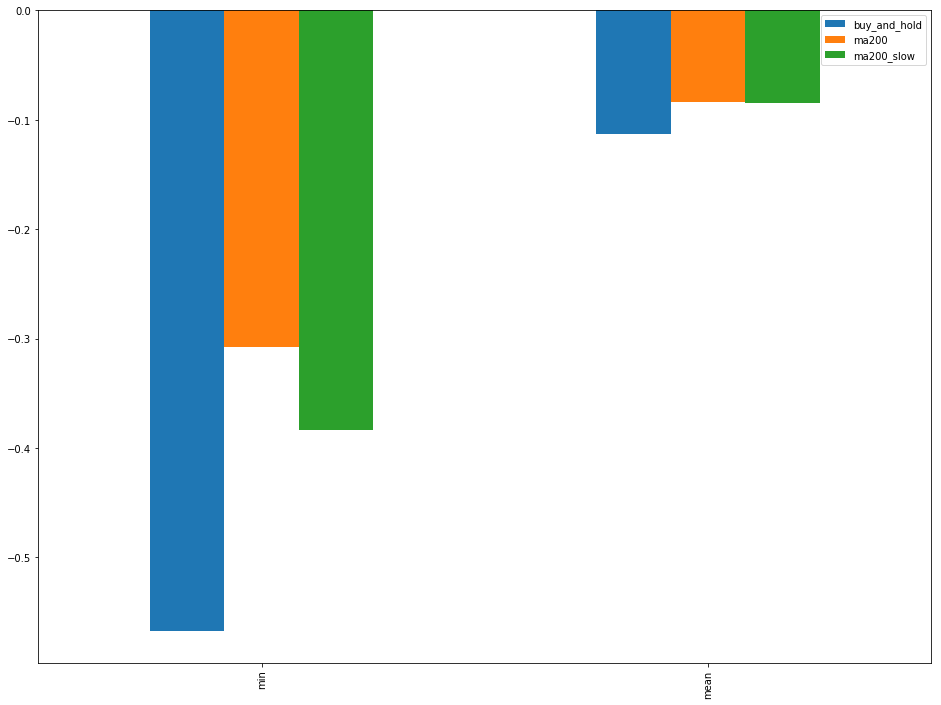

In [22]:
# Drawdowns
dd = (
    strats.mul(rets, axis=0)
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1)
)
dd_agg = dd.agg(['min', 'mean'])
print(dd_agg)
dd_agg.plot.bar()

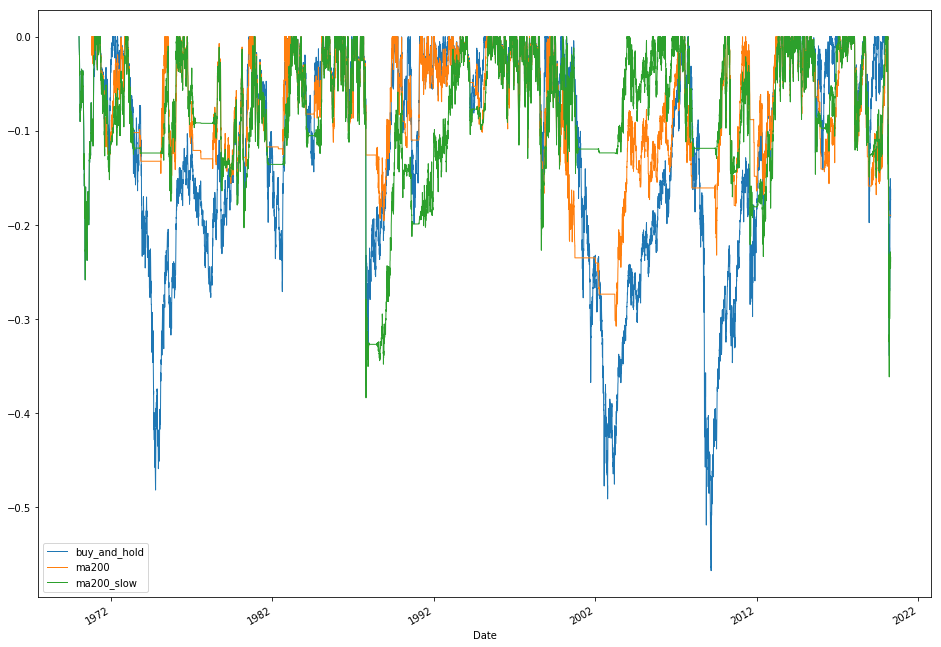

In [23]:
# Drawdowns side by side
dd.plot(lw=1)

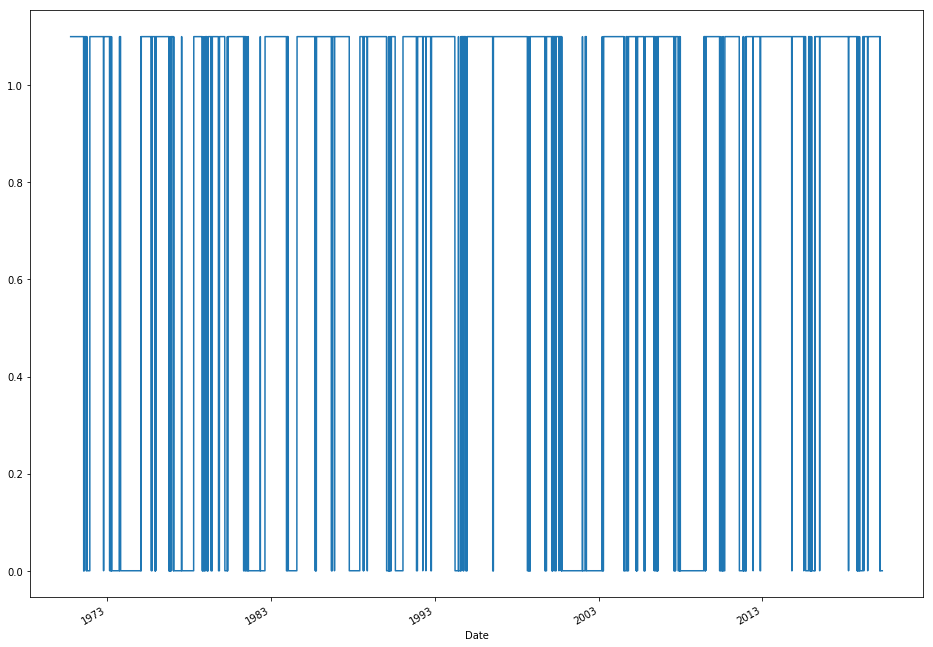

In [24]:
# Original signal slams on and off
strats.ma200.plot()

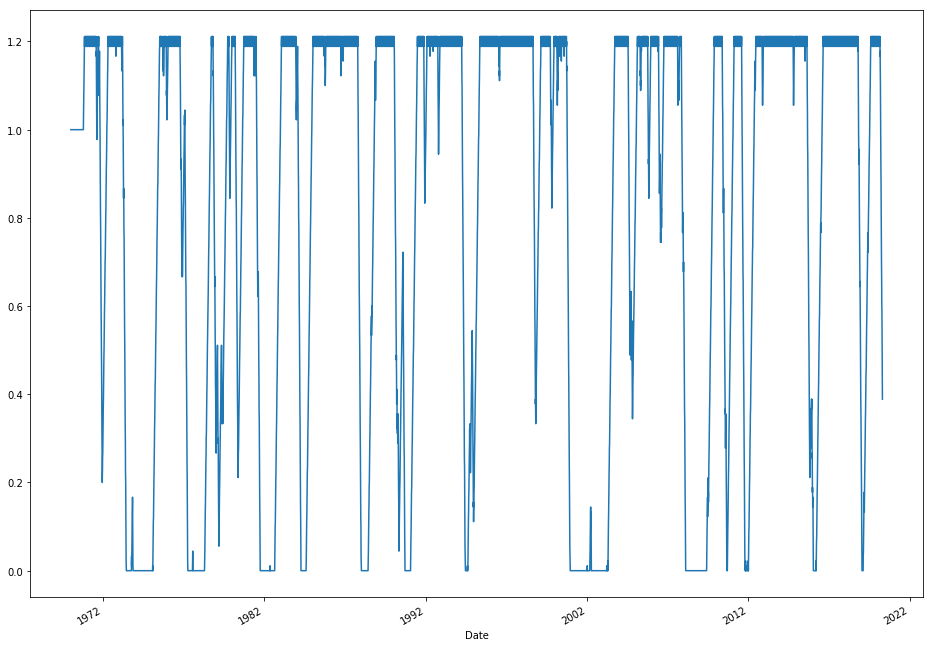

In [25]:
# New signal drifts in and out
strats.ma200_slow.plot()

In [26]:
# The original signal has trades on 4.2% of all days
strats.ma200.diff().ne(0).mean()

0.04238890639773085

In [27]:
# Smoothened signal trades (a much smaller amount in aggregate) on ~30% of all days
strats.ma200_slow.diff().ne(0).mean()

0.8143712574850299

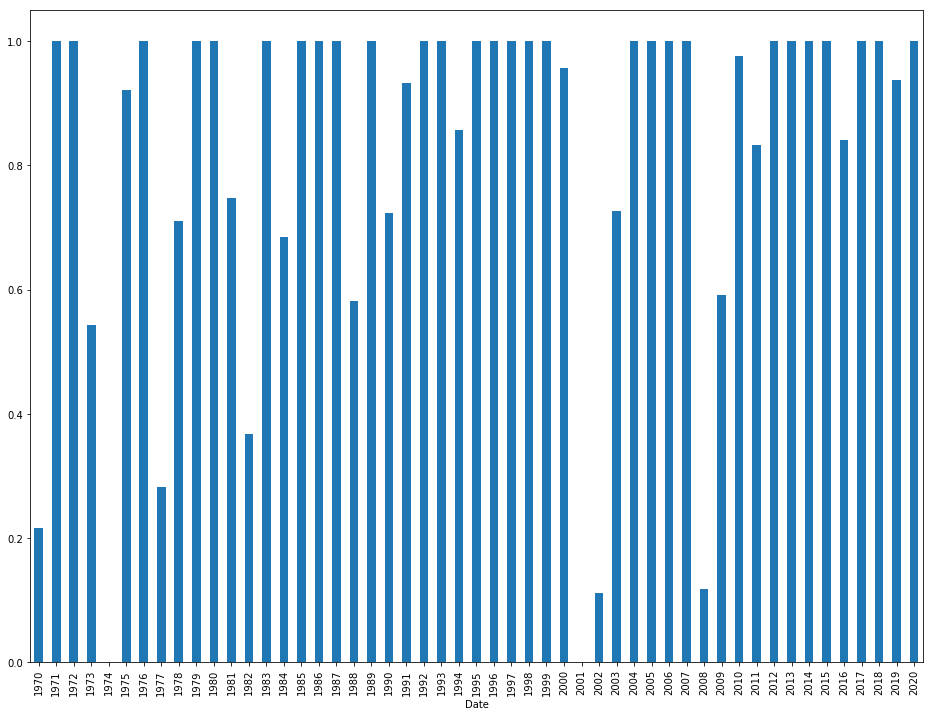

In [28]:
# Some years as many as 80% of all days
strats.ma200_slow.diff().ne(0).groupby(pd.Grouper(freq='Y')).mean().rename(index=lambda xs: xs.year).plot.bar()

In [29]:
# Account for how allocation drifts with return 
# f.(r + 1) / (f.r + 1)
pos_with_drift = (
    strats.shift().mul(rets + 1, axis=0)
    .div(strats.shift().mul(rets, axis=0).add(1), axis=0)
)
# Assume 20 bps transaction cost
costs = strats.sub(pos_with_drift).abs().mul(20. / 10000)

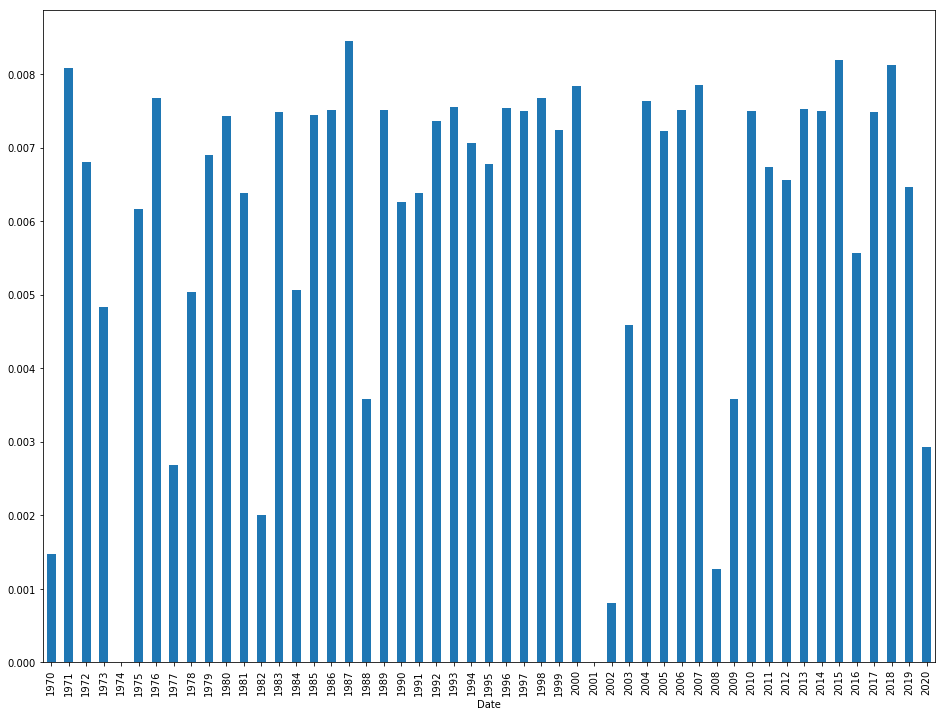

In [30]:
# Slow strategy costs at most 50 bps a year to execute
costs.ma200_slow.groupby(pd.Grouper(freq='Y')).sum().rename(index=lambda xs: xs.year).plot.bar()

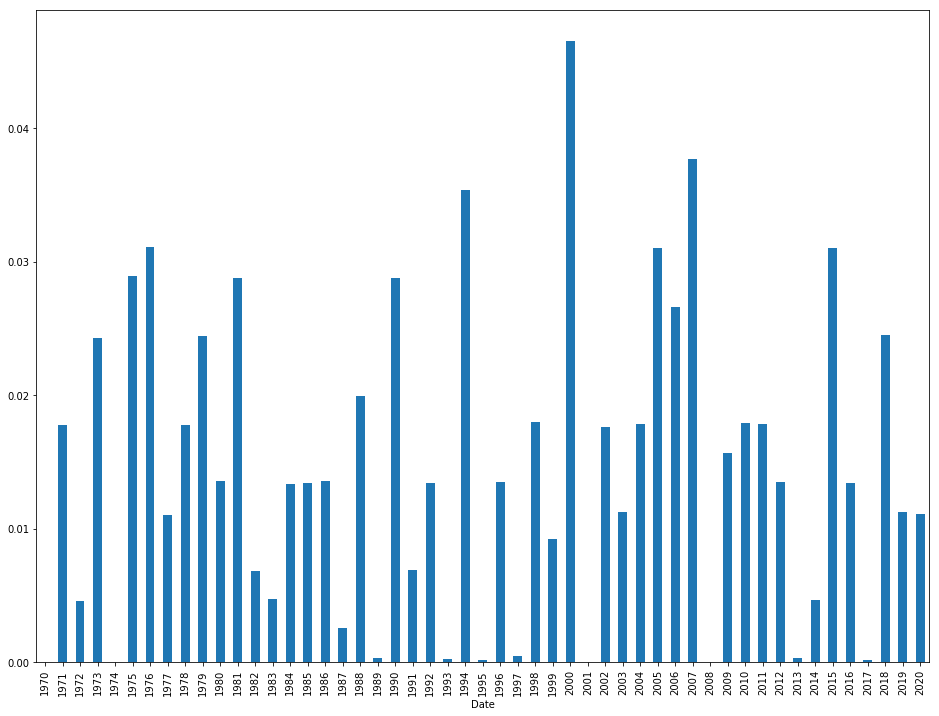

In [31]:
# Contrast with original signal - a few percent a year!
costs.ma200.groupby(pd.Grouper(freq='Y')).sum().rename(index=lambda xs: xs.year).plot.bar()

In [32]:
rets_after_costs = strats.mul(rets, axis=0) - costs

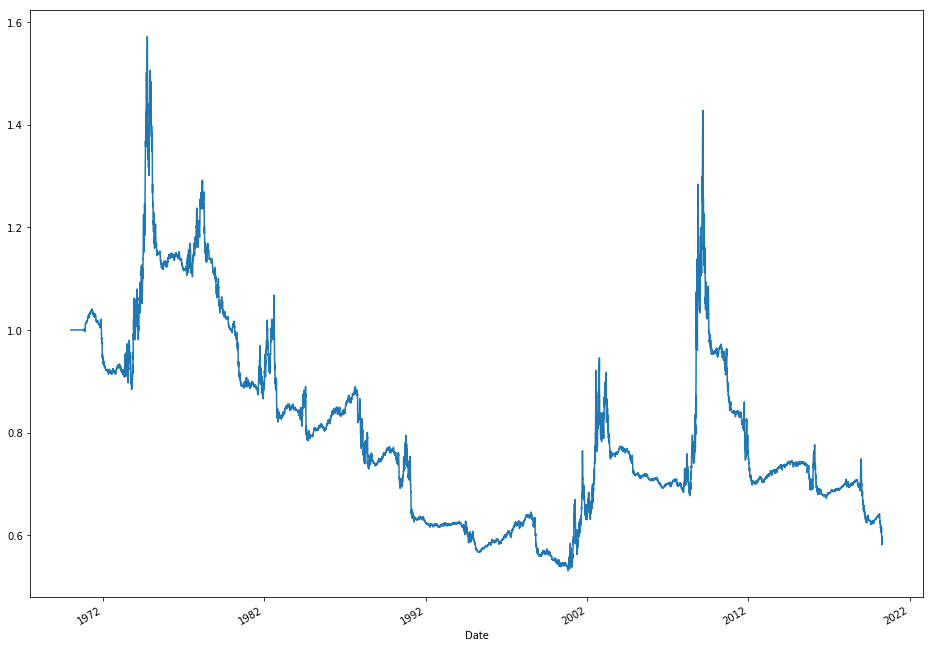

In [33]:
# Difference from buy and hold by year
(
    (rets_after_costs.ma200_slow + 1) 
    .div(rets_after_costs.buy_and_hold + 1)
    .cumprod().plot()
)

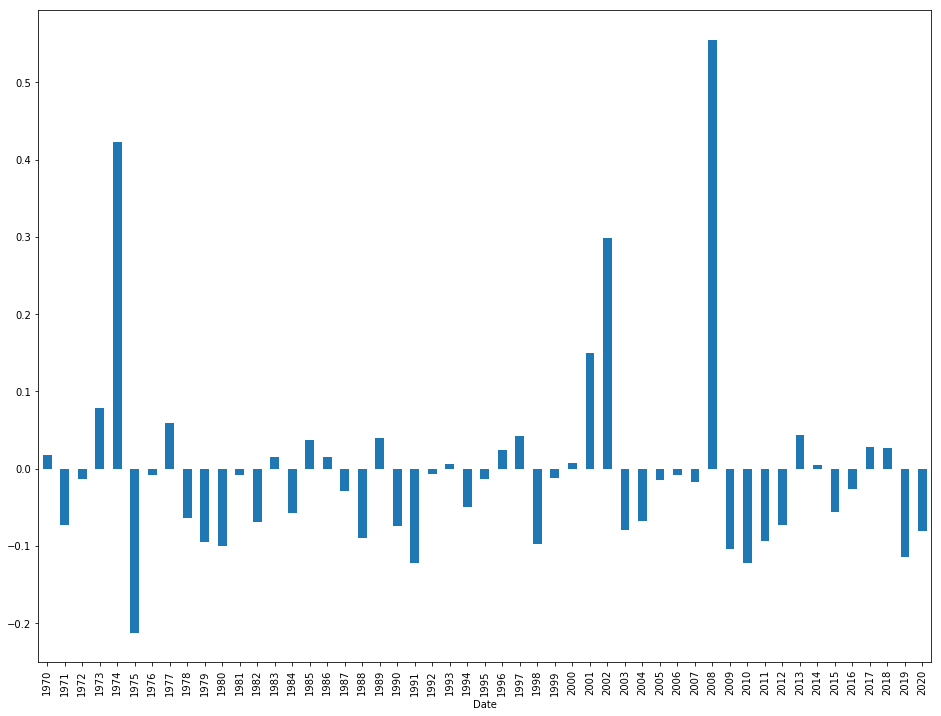

In [34]:
# Difference from buy and hold by year
(
    (rets_after_costs.ma200_slow + 1) 
    .div(rets_after_costs.buy_and_hold + 1)
    .groupby(pd.Grouper(freq='Y')).prod().sub(1)
    .rename(index=lambda xs: xs.year).plot.bar()
)

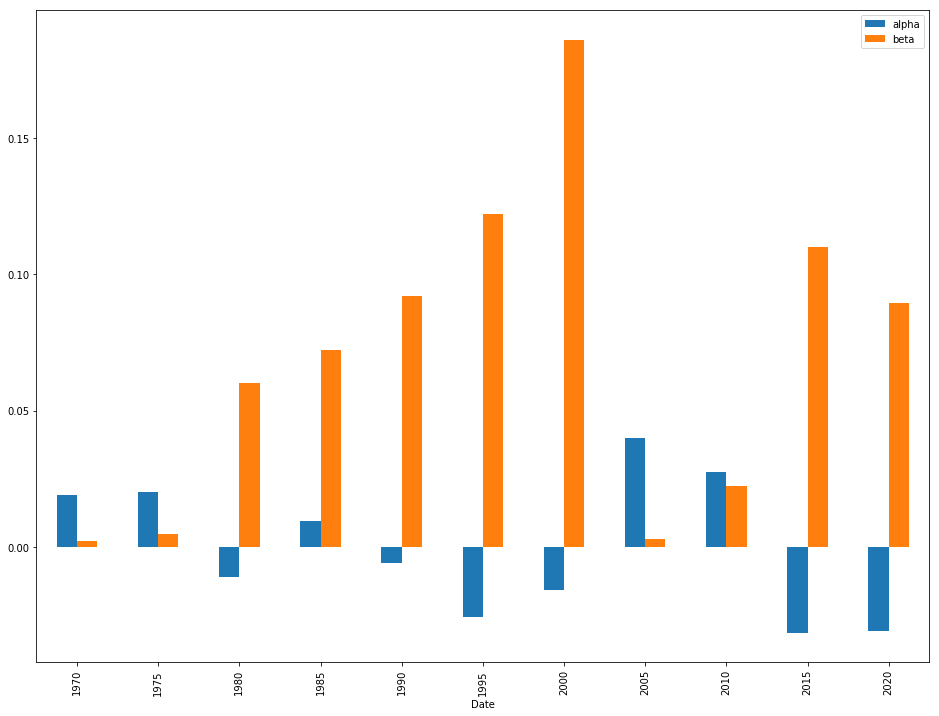

In [35]:
# Pretty much no alpha! This is just risk management.
(
    pd.concat([strats.ma200_slow.rename('pos'), rets], axis=1)
    .assign(strat_rets=lambda df: df.pos * df.rets)
    .groupby(pd.Grouper(freq='5Y'))
    .mean()
    .assign(
        beta=lambda df: df.pos * df.rets, 
        alpha=lambda df: df.strat_rets - df.beta
    ).mul(250)
    [['alpha', 'beta']]
    .rename(index=lambda xs: xs.year).plot.bar()
)

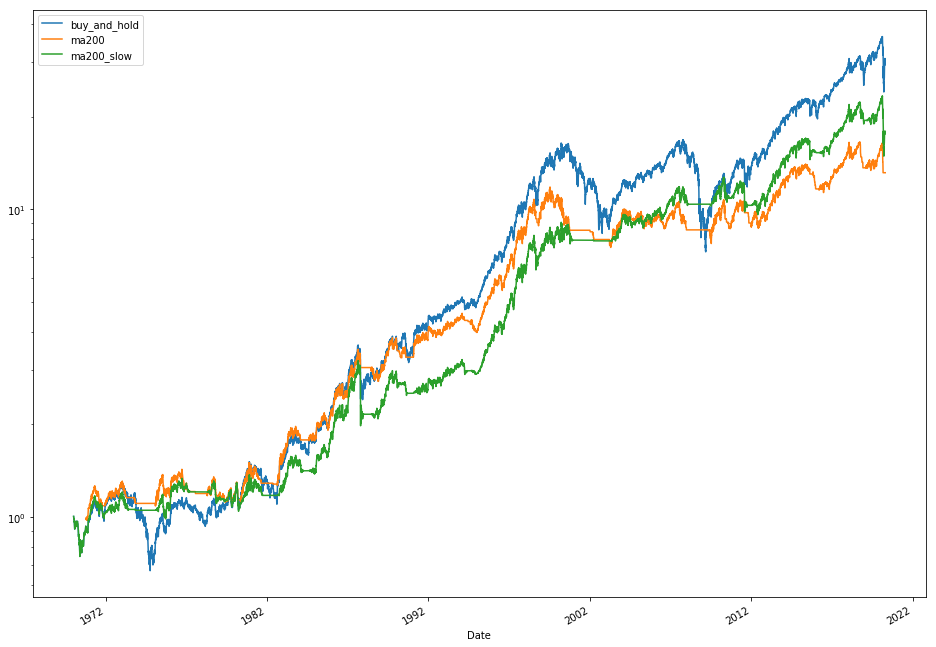

In [36]:
# Side by side, with transaction costs
rets_after_costs.add(1).cumprod().plot(logy=True)

In [37]:
# Sharpe ratios
rets_after_costs.agg(lambda xs: xs.mean() / xs.std() * 250**0.5)

buy_and_hold    0.479906
ma200           0.488537
ma200_slow      0.472504
dtype: float64